# Standardising Australia Hazard Maps

The goal of this notebook is to develop and provide examples of mapping climate hazards for Australia so that data can be consistently presented.
Examples will include maps for Australia and for selected states or regions.

In [1]:
import datetime
datetime.datetime.now()

datetime.datetime(2024, 5, 31, 19, 28, 32, 608324)

In [2]:
import sys
print(sys.executable)

/g/data/hh5/public/./apps/cms_conda/envs/analysis3-24.04/bin/python


In [3]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [4]:
# Plot Australian map without hazard

In [5]:
import xarray as xr

In [6]:
import matplotlib.cm as cm

In [7]:
# code adapted from https://stackoverflow.com/questions/75668431/plotting-points-on-australia-map-in-python

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns

# Define the list of cities and their latitudes/longitudes
cities = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Canberra', 'Hobart', 'Darwin']
lats = [-33.865143, -37.813629, -27.469771, -31.953512, -34.928499,  -35.282001, -42.8821, -12.4637]
longs = [151.209900, 144.963165, 153.025124, 115.857048, 138.600739, 149.128998, 147.3272, 130.8444]


crs = 'epsg:7844'
xlim = (110,170)
ylim = (-45, -5)


# Create the DataFrame with the city data
data = {'cityname': cities,
        'lats': lats,
        'longs': longs,}
df = pd.DataFrame(data)
df.columns=['name', 'lat', 'lon']
df

,name,lat,lon
0,Sydney,-33.865143,151.209900
1,Melbourne,-37.813629,144.963165
2,Brisbane,-27.469771,153.025124
3,Perth,-31.953512,115.857048
4,Adelaide,-34.928499,138.600739
5,Canberra,-35.282001,149.128998
6,Hobart,-42.882100,147.327200
7,Darwin,-12.463700,130.844400


In [8]:
logo = image.imread("ACS_Logo_Blue_on_white_Stacked.png")

In [9]:
from shapely.geometry import box

name = "australia"
australia = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

# Define the CRS of the shapefile manually
australia.crs = crs

map_total_bounds = [xlim[0], ylim[0], xlim[1], ylim[1]]
# map_total_bounds = australia.total_bounds

not_australia = gpd.GeoSeries(data = [box(*box(*map_total_bounds).bounds).difference(australia["geometry"].values[0])],
                              crs=crs,)


In [10]:
str(datetime.datetime.now().date())

'2024-05-31'

In [11]:
def plot_aus_shapefiles(name =  "aus_states_territories",
                        data = None,
                        facecolor = None, 
                        edgecolor = "black",
                        figsize = (8,6),
                        title = None,
                        crs = 'epsg:7844',
                        area_linewidth = 0.3,
                        xlim = (110,170),
                        ylim = (-45, -10),
                        cmap = None,
                        varname = None,
                        cbar_extent = "both",
                        date_range = "",
                        mask_not_australia = True,
                        issued_date = datetime.datetime.today().date().strftime('%d/%m/%Y'),
                        dataset_name = None,
                        baseline = None,
                        
                       ):
    """This function takes a name of a Australian shapefile collection for data in /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ 
    and plots a map of Australia with the shape outlines. The map is saved as a png in your working directory.
    This function returns fig and ax.
    facecolor reccommendations include "white", "lightgrey", "none"
    edgecolor reccomendations include "black" and "white"
    """

    try:
        gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')
    except:
        print(f"Could not read /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp")
        
    # Define the CRS of the shapefile manually
    gdf.crs = crs

    # Set up the plot
    # sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=figsize)
    
    if data is not None:
        # plot the hazard data
        plt.pcolormesh(data.lon, data.lat, data, cmap = cmap,)
        cbar = plt.colorbar( extend = cbar_extent, cax=ax.inset_axes([0.85,0.2, 0.03, 0.6]), )
        cbar.ax.set_ylabel(varname)
        
        facecolor = "none"

    if mask_not_australia:
        # outside the shape, fill white
        not_australia.plot(ax=ax, facecolor="white", linewidth=0)
        # plot the shape edges, eg state borders
    
    
    gdf.plot(ax=ax,
             facecolor=facecolor,
             edgecolor=edgecolor, 
             linewidth=area_linewidth,
            )
    
    # Set the plot title and axis labels
    if title is None:
        title = name

    ax = plt.gca()
    ax.text(0.15,0.1,f"{title}\n{date_range}",
            horizontalalignment='left',
            transform=ax.transAxes)

    # Place logo in top left
    ax.imshow(logo, extent=(0.0, 0.3, 0.85, 1.0),  transform=ax.transAxes, zorder = 10) 
    # print base period inside bottom left corner
    ax.text(x=0.01, y=0.01, s= f"Base period: {baseline}", fontsize=6, transform=ax.transAxes)
    # print copyright outside bottom left corner
    ax.text(x=0.01, y=-0.03, s= f"(C) Commonwealth of Australia {datetime.datetime.now().year}, Australian Climate Service", fontsize=6, transform=ax.transAxes)
    # print data source inside bottom right
    ax.text(x=0.99, y=0.01, s= f"Dataset: {dataset_name}", fontsize=6, transform=ax.transAxes, horizontalalignment="right")
    ax.text(x=0.99, y=-0.03, s= f"Issued: {issued_date}", fontsize=6, transform=ax.transAxes, horizontalalignment="right")


    
    
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.tick_params(axis="both", which = "both", bottom =False, left=False, labelbottom = False, labelleft=False)
    
    plt.tight_layout()
    # Show the plot
    plt.savefig(f"{name}.png",)
    return fig, ax

In [12]:
shape_files = [ "aus_local_gov", "aus_states_territories", "australia", "nrm_regions", "river_regions"]

In [13]:
broadacre_file = '/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/broadacre_regions/aagis_asgs16v1_g5a.shp'


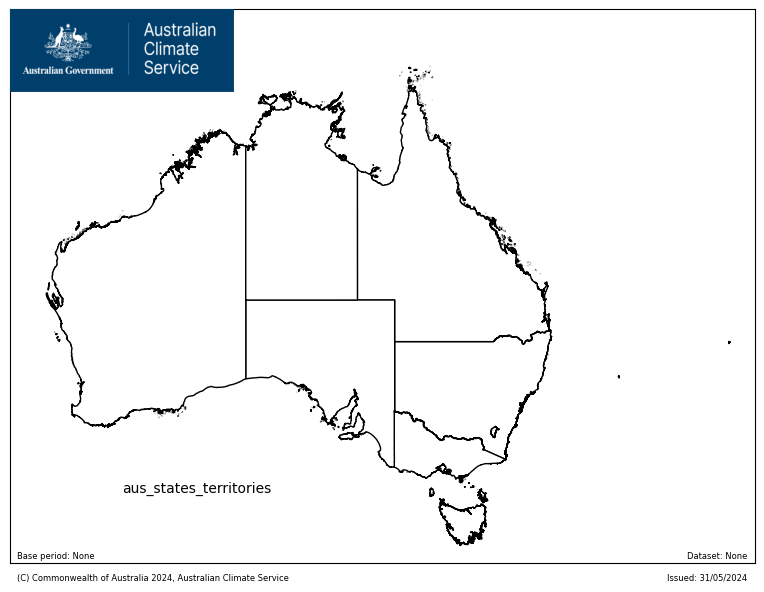

In [14]:
name =  "aus_states_territories"
facecolor = "white" # "lightgrey", "none"
edgecolor = "black" # "white"
title = name
area_linewidth = 1

cmap= None

plot_aus_shapefiles(name = name,
                    facecolor = facecolor, 
                    edgecolor = edgecolor,
                    title = None,
                    crs = crs,
                    area_linewidth = area_linewidth,
                    xlim = xlim,
                    ylim = ylim,
                    cmap = cmap,
                   mask_not_australia = True);

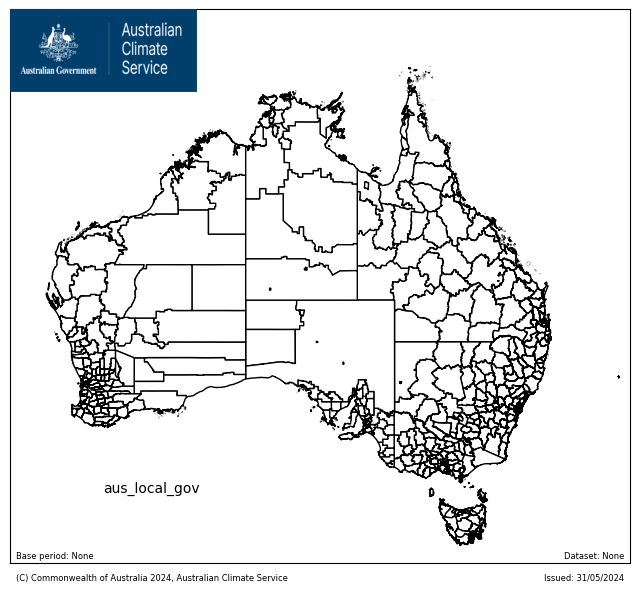

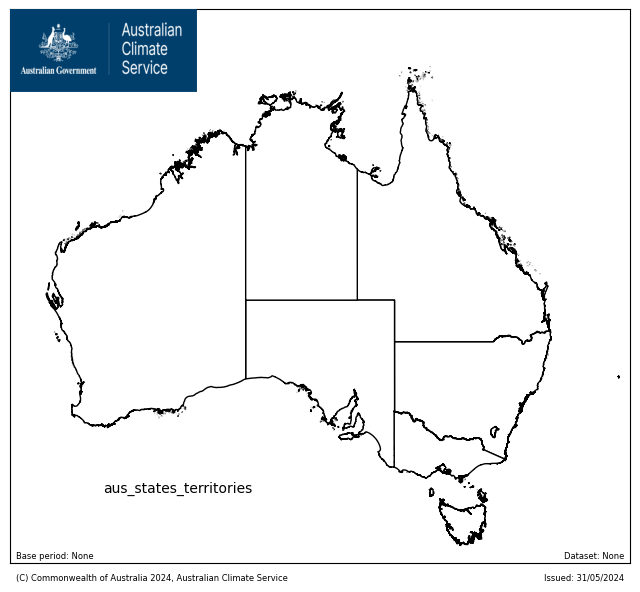

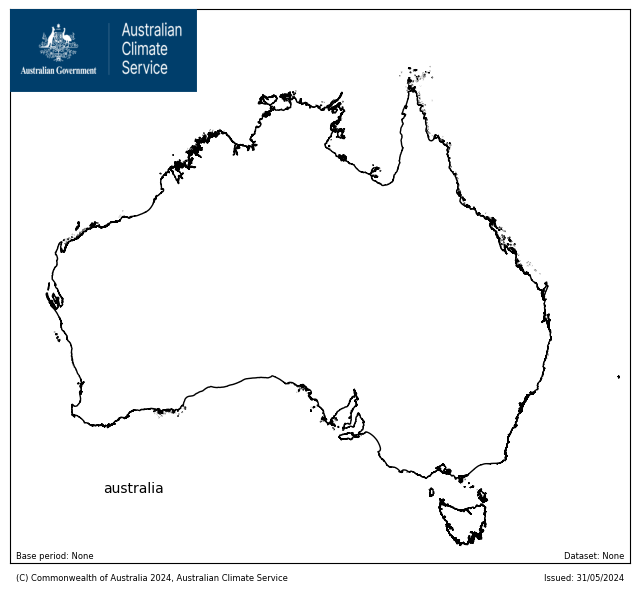

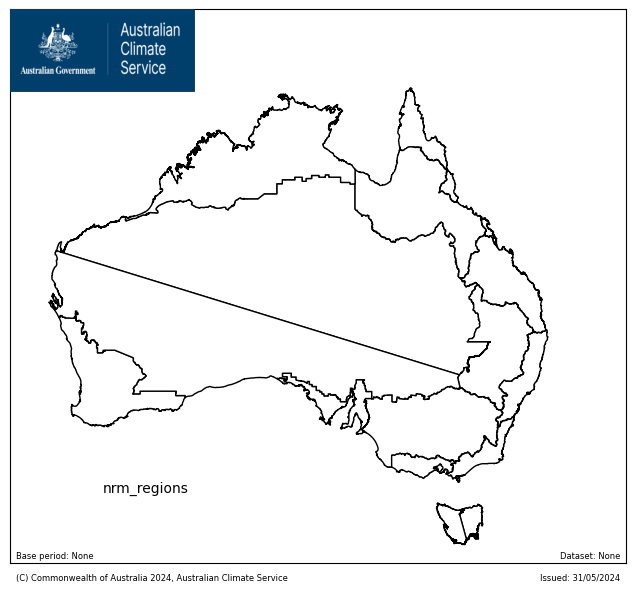

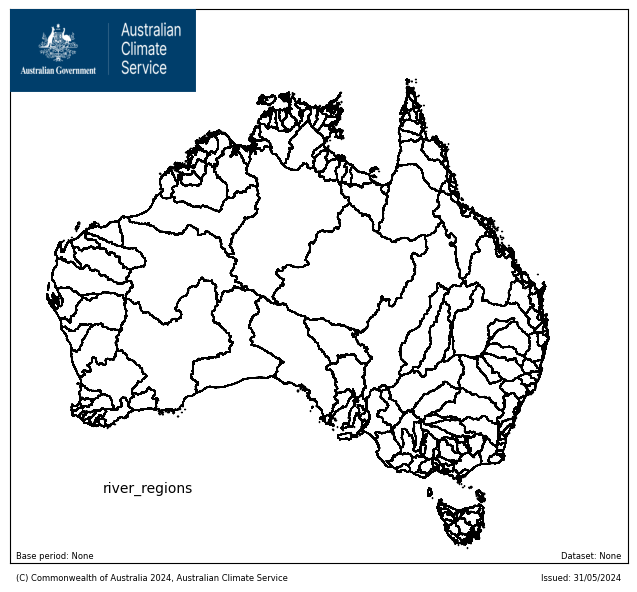

In [15]:
facecolor = "white" # "lightgrey", "none"
edgecolor = "black" # "white"
title = name
crs = 'epsg:7844'
area_linewidth = 1
xlim = (110,160)
ylim = (-45, -5)

for name in shape_files:
    plot_aus_shapefiles(name = name,
                        facecolor = facecolor, 
                        edgecolor = edgecolor,
                        title = None,
                        crs = crs,
                        area_linewidth = area_linewidth,
                        xlim = xlim,
                        ylim = ylim);


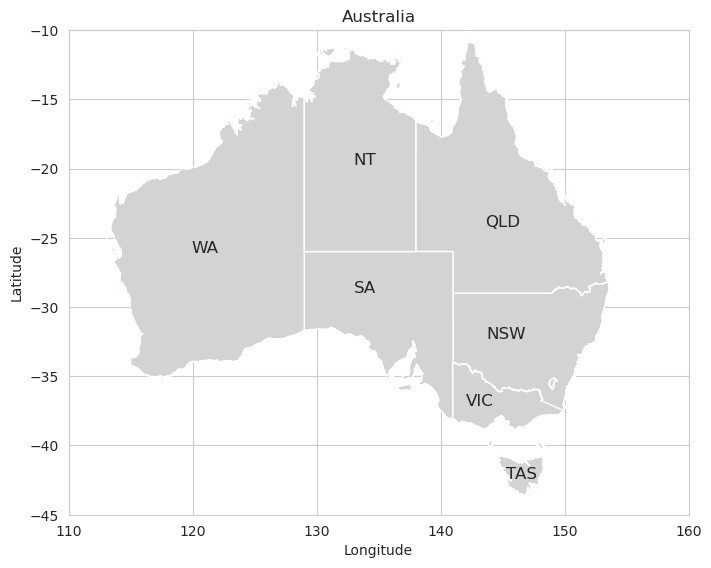

In [16]:
name =  "aus_states_territories"


aus_states_territories = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

# Set up the plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 8))


# Add the shapefile of Australia as a background map
aus_states_territories.plot(ax=ax, color='lightgrey', edgecolor='white')

# sns.scatterplot(ax=ax, data=data, x='longs', y='lats', s=100, legend='full')

states = ["WA", "NT", "SA", "QLD", "NSW", "VIC", "TAS"]
lats = [-26.06, -19.7, -29.0, -24.2, -32.3, -37.1, -42.4]
lons = [119.9, 133,  133, 143.6, 143.7, 142.0, 145.3]

for lon, lat, state in zip(lons, lats, states):
    plt.text(lon, lat, state, size=12)

# Set the plot title and axis labels
plt.title('Australia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(110,160)
plt.ylim(-45, -10)

# Show the plot
plt.savefig("aus_states.png", )
# plt.savefig("aus_states.svg", )


In [17]:
# Plot Australian map

In [18]:
# Plot Australian map with states

In [19]:
# plot one state

In [20]:
gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')
gdf.loc[gdf.STE_NAME21=="Victoria"]

,STE_NAME21,AREASQKM21,LOCI_URI21,geometry
1,Victoria,227496.2479,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."


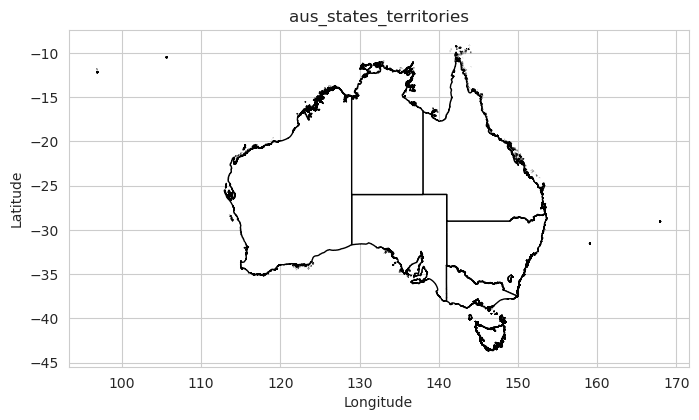

In [21]:
figsize=(8,6)

vic = gdf.loc[gdf.STE_NAME21=="Victoria"] 
# Define the CRS of the shapefile manually
gdf.crs = crs

# Set up the plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figsize)

# Add the shapefile of Australia as a background map
gdf.plot(ax=ax,
         facecolor=facecolor,
         edgecolor=edgecolor, 
         linewidth=area_linewidth,
         cmap = cmap,
        )

# Set the plot title and axis labels
if title == None:
    plt.title(name)
else:
    plt.title(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')


# Show the plot
plt.savefig(f"{name}.png",)

In [22]:
ds = xr.open_dataset("/g/data/lp01/CORDEX-CMIP6/CMIP6/DD/gr1.5/CSIRO/ACCESS-CM2/historical/r4i1p1f1/CCAM-v2203-SN/v1-r1/mon/tas/v20231206/tas_gr1.5_ACCESS-CM2_historical_r4i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_mon_195101-201412.nc")
ds

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 768, lon: 62, lat: 41)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1951-01-15T12:00:00 ... 2014-12-15T12:...
  * lon      (lon) float64 496B 90.0 91.5 93.0 94.5 ... 177.0 178.5 180.0 181.5
  * lat      (lat) float64 328B -51.75 -50.25 -48.75 -47.25 ... 5.25 6.75 8.25
Data variables:
    tas      (time, lat, lon) float32 8MB ...
Attributes: (12/32)
    CDI:                       Climate Data Interface version 2.2.1 (https://...
    Conventions:               CF-1.10
    source:                    Conformal Cubic Atmospheric Model v2203
    institution:               Commonwealth Scientific and Industrial Researc...
    axiom_version:             0.2.0
    axiom_schema:              CORDEX
    ...                        ...
    tracking_id:               0fba49e2-43d5-4afc-afee-47ff1aee832d
    variable_id:               tas
    doi:                       https://doi.org/10.25914/rd73-4m38
    history:                   Fri Feb 16 21:44:02 2024: cdo -O -s -L -P 28 -...
    CDO:                       Climate Data Operators version 2.2.0 (https://...
    cdo_openmp_thread_number:  28

In [23]:
pwd

'/g/data/mn51/users/gt3409/plotting_maps'

In [24]:
import cmaps

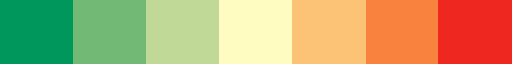

In [25]:
cmaps.drought_severity

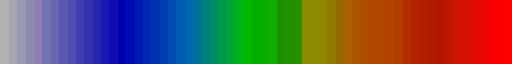

In [26]:
cmaps.temp1

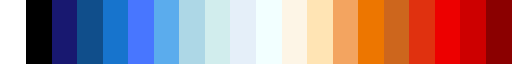

In [27]:
cmaps.posneg_2

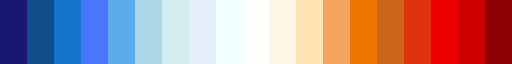

In [28]:
cmaps.hotcold_18lev

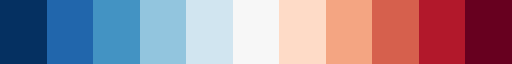

In [29]:
cmaps.CBR_coldhot

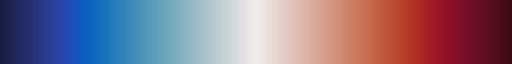

In [30]:
cmaps.cmocean_balance

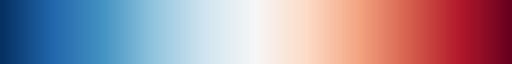

In [31]:
cm.RdBu_r

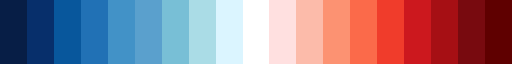

In [32]:
cmaps.temp_diff_18lev

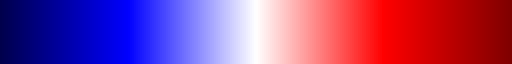

In [33]:
cm.seismic

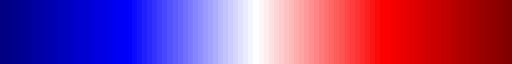

In [34]:
cmaps.BlWhRe

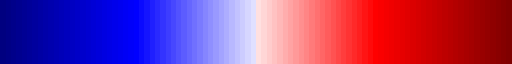

In [35]:
cmaps.BlRe

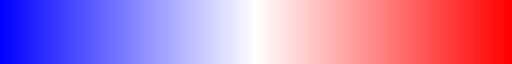

In [36]:
cm.bwr

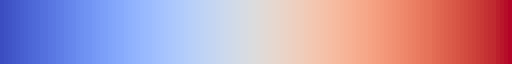

In [37]:
cmaps.MPL_coolwarm

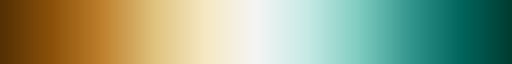

In [38]:
cm.BrBG

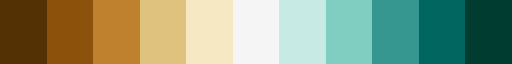

In [39]:
cmaps.CBR_drywet

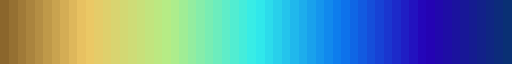

In [40]:
cmaps.GMT_drywet

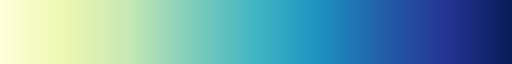

In [41]:
cm.YlGnBu

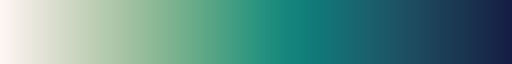

In [42]:
cmaps.cmocean_tempo

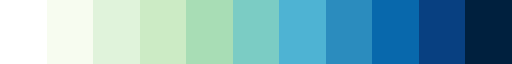

In [43]:
cmaps.CBR_wet

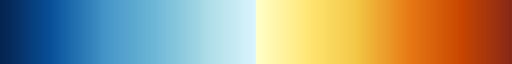

In [44]:
cmaps.BlueYellowRed

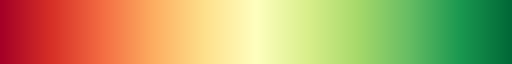

In [45]:
cm.RdYlGn

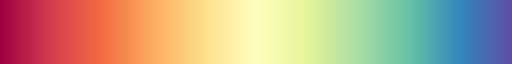

In [46]:
cm.Spectral

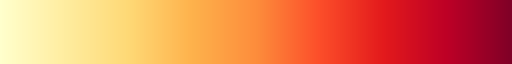

In [47]:
cm.YlOrRd

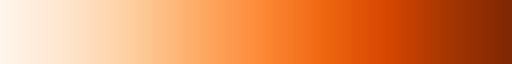

In [48]:
cm.Oranges

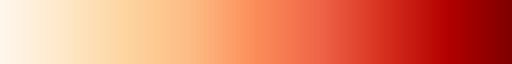

In [49]:
cm.OrRd

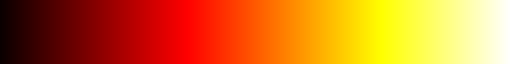

In [50]:
cm.hot

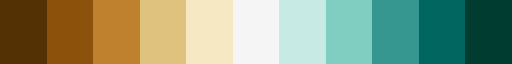

In [51]:
cmaps.CBR_drywet

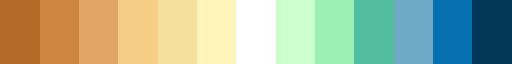

In [52]:
cmaps.precip_diff_12lev

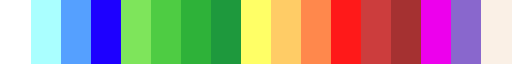

In [53]:
cmaps.prcp_1

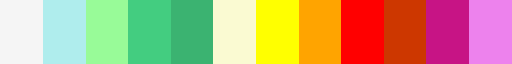

In [54]:
cmaps.prcp_2

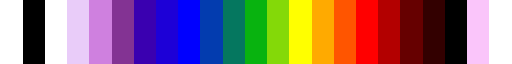

In [55]:
cmaps.prcp_3

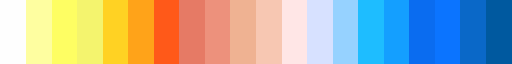

In [56]:
cmaps.rh_19lev

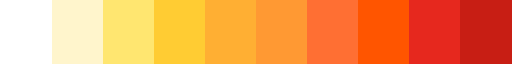

In [57]:
cmaps.sunshine_9lev

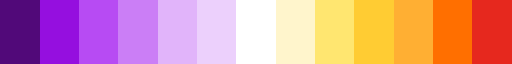

In [58]:
cmaps.sunshine_diff_12lev

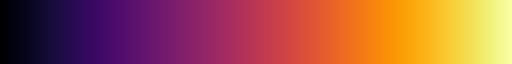

In [59]:
cm.inferno

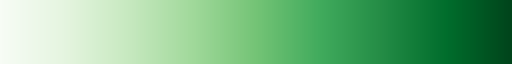

In [60]:
cm.Greens

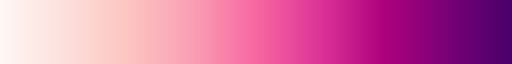

In [61]:
cm.RdPu

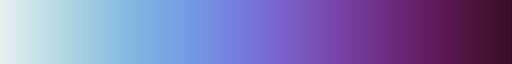

In [62]:
cmaps.cmocean_dense

In [63]:
# These are a dictionary of suggested colormaps
## I am not sure where these all come from. They are not all standard color maps
# see here: https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml

cmap_dict = {"temperature_diverging_01": "lclbluewhitered",
             "temperature_diverging_02": "cmobalance",
             "temperature_diverging_03": "cmpbluered",
             "temperature_diverging_04": "lclclimtemp",
             "temperature_01": "revheat",
             "temperature_02": "mplrevhot",
             "ffdi_01": "gmtrevhot",
             "ffdi_02": "mplrevafmhot",
             "ffdi_03": "lcbyellowred",
             "ffdi_04": "mplyelloworangebrown",
             "ffdi_05": "cmomatter",
             "ffdi_category": ("green", "blue", "yellow", "orange", "red", "darkred"),
             "temperature_deciles_01": "lclbluewhitered",
             "temperature_deciles_02": "lcldarkbluewhitedarkred",
             "temperature_deciles_03": "cmobalance",
             "pr_diverging_01": "mplbrowngreen",
             "pr_01": "mplyellowgreenblue",
             "pr_02": "cmotempo",
             "pr_03": "cmonegthermal",
             "other_01": "myinferno",
             "other_02": "mplgreens",
             "other_03": "mplredpurple",
             "other_04": "cmodense",
            }

# kwargs may include spacing = "uniform", drwaedges=False, label=cbar_label, ticks=cbar_tick


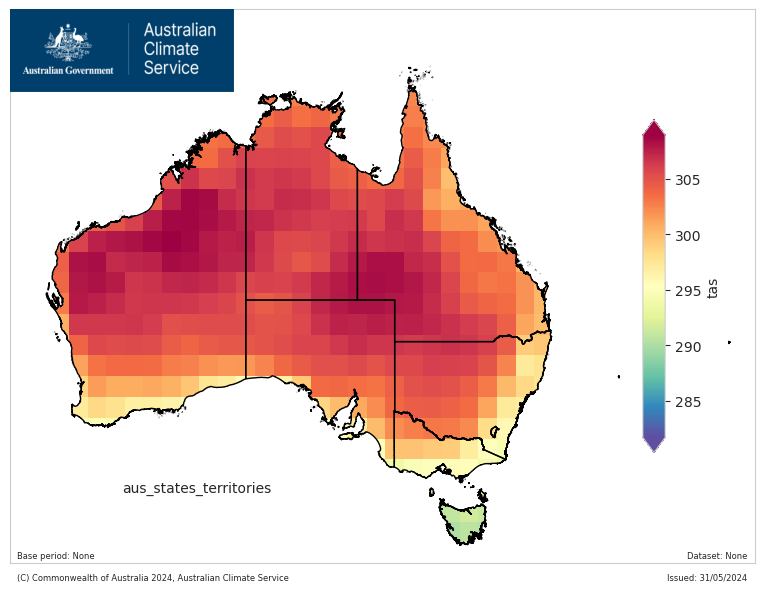

In [64]:
facecolor = "white" # "lightgrey", "none"
edgecolor = "black" # "white"
title = name
crs = 'epsg:7844'
area_linewidth = 1
xlim = (110,170)
ylim = (-45, -5)
data = ds.tas.max(dim="time")
cmap = cm.Spectral_r
varname = "tas"
cbar_extent="both"


plot_aus_shapefiles(name = name,
                    data = data,
                    facecolor = facecolor, 
                    edgecolor = edgecolor,
                    title = None,
                    crs = crs,
                    area_linewidth = area_linewidth,
                    xlim = xlim,
                    ylim = ylim,
                    cmap = cmap,
                    cbar_extent = cbar_extent,
                    varname = varname,
                    );

(-40.1591764702752, -32.98063640290455)

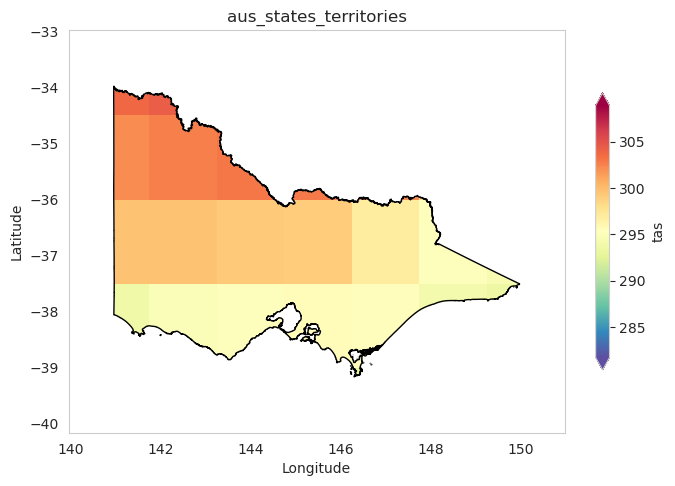

In [65]:

name = "aus_states_territories" 
gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

# Define the CRS of the shapefile manually
gdf.crs = crs

# selct state
vic = gdf.loc[gdf.STE_NAME21=="Victoria"] 


# map_total_bounds = [xlim[0], ylim[0], xlim[1], ylim[1]]
map_total_bounds = vic.total_bounds

not_vic = gpd.GeoSeries(data = [box(*box(*map_total_bounds).buffer(1.0).bounds).difference(vic["geometry"].values[0])],
                              crs=crs,)

minx, miny, maxx, maxy = not_vic.total_bounds

try:
    gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')
except:
    print(f"Could not read /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp")
    
# Define the CRS of the shapefile manually
gdf.crs = crs

# Set up the plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figsize)

if data is not None:
    # plot the hazard data
    plt.pcolormesh(data.lon, data.lat, data, cmap = cmap,)
    cbar = plt.colorbar( shrink = 0.6, extend = cbar_extent)
    cbar.ax.set_ylabel(varname)
    
    facecolor = "none"

# outside the shape, fill white
not_vic.plot(ax=ax, facecolor="white", linewidth=0)
# plot the shape edges, eg state borders


vic.plot(ax=ax,
         facecolor=facecolor,
         edgecolor=edgecolor, 
         linewidth=area_linewidth,
        )

# Set the plot title and axis labels
if title is None:
    plt.title(name)
else:
    plt.title(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

# Show the plot
# plt.savefig(f"{name}.png",)


(-40.1591764702752, -32.98063640290455)

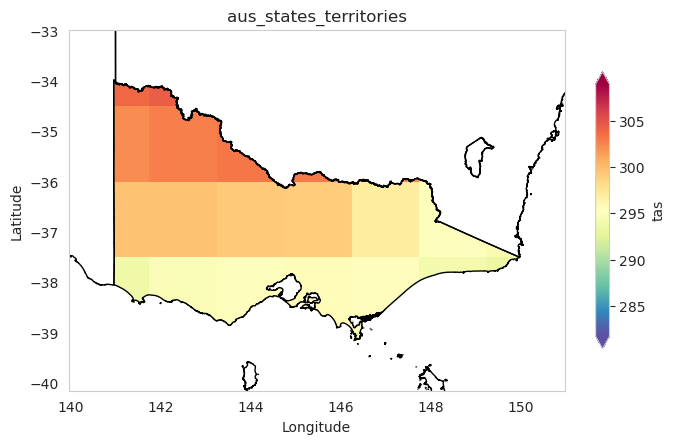

In [66]:
name = "aus_states_territories" 
gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

# Define the CRS of the shapefile manually
gdf.crs = crs

# selct state
vic = gdf.loc[gdf.STE_NAME21=="Victoria"] 


# map_total_bounds = [xlim[0], ylim[0], xlim[1], ylim[1]]
map_total_bounds = vic.total_bounds

not_vic = gpd.GeoSeries(data = [box(*box(*map_total_bounds).buffer(1.0).bounds).difference(vic["geometry"].values[0])],
                              crs=crs,)

minx, miny, maxx, maxy = not_vic.total_bounds

try:
    gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')
except:
    print(f"Could not read /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp")
    
# Define the CRS of the shapefile manually
gdf.crs = crs

# Set up the plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=figsize)

if data is not None:
    # plot the hazard data
    plt.pcolormesh(data.lon, data.lat, data, cmap = cmap,)
    cbar = plt.colorbar( shrink = 0.6, extend = cbar_extent)
    cbar.ax.set_ylabel(varname)
    
    facecolor = "none"

# outside the shape, fill white
not_vic.plot(ax=ax, facecolor="white", linewidth=0)
# plot the shape edges, eg state borders


gdf.plot(ax=ax,
         facecolor=facecolor,
         edgecolor=edgecolor, 
         linewidth=area_linewidth,
        )

# Set the plot title and axis labels
if title is None:
    plt.title(name)
else:
    plt.title(title)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

# Show the plot
# plt.savefig(f"{name}.png",)

To do:
- test with different data
- dictionary of cmap for different hazard types
- option for cmap steps. some predefined eg see Document
- option for gridded data/ smooth / contours
- crop large white space around figure
